![](files/Fasshauer.png)

In [2]:
using SpecialFunctions, Laplacians, KernelMatrices, LinearAlgebra, Plots

function dist(x, z, d = 2)
    return (sum((x .- z).^d))^(1/d)
end

function matkern(dis::Number, epsilon::Number, m::Number, d::Int = 2)
    if dis == 0.0 
        return 1.0
    else
        return besselk(m-d/2, epsilon*dis)*(epsilon*dis)^(m-d/2)
    end
end

matkern (generic function with 2 methods)

[103, 134, 135, 136, 165, 166, 167, 168, 169, 186, 198, 199, 200, 217, 218, 219, 231, 246, 248, 249, 250, 251, 252, 277, 278, 279, 281, 282, 283, 303, 308, 309, 310, 311, 312, 314, 334, 335, 336, 341, 342, 343, 365, 366, 367, 368, 369, 374, 398, 399, 400, 431]
There are 52 missing.


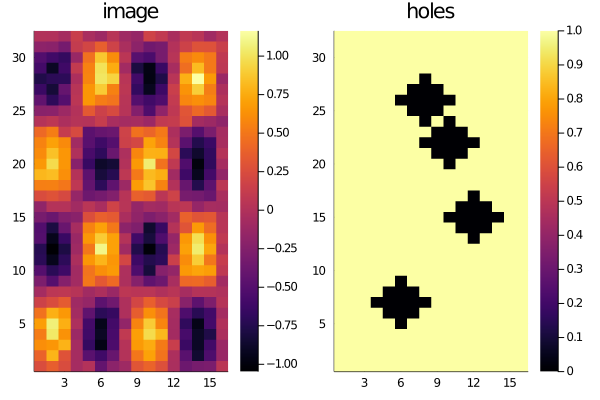

In [3]:
L = 32
K = 16
a_num = (L,K) # length vectors for a 2D problem
x1 = 1:a_num[1]
x2 = 1:a_num[2]
d = length(a_num)
img = sin.(2*pi*x1/16)*sin.(2*pi*x2'/8) + randn(a_num)*0.1


cent = [(7,6), (15,12), (22,10), (26, 8)]
rad = 2.0

function prod_dot(m)
    mas = m[1]
    for i = 2:length(m)
        mas .*= m[i]
    end
    return mas
end

mask = map(c->broadcast(+, (x1 .- c[1]).^2, (x2 .- c[2])'.^2) .> rad^2, cent)
mask = prod_dot(mask)

# Find where the data are missing
inds = sortperm(mask[:])
S = L*K-sum(mask)
missing_inds = inds[1:S]
println(missing_inds)
nonmissing_inds = inds[(S+1):end]

println("There are $S missing.")

p1 = heatmap(img, title = "image")
p2 = heatmap(mask, title = "holes")

plot(p1,p2,layout=(1,2))

From Rasmussen and Williams book:
![](files/RW_GP_Pred.png)

In [10]:
# No noise is assumed, sigsq_n = 0

xx = [[x,y] for x in x1 for y in x2]
xxyy = [(x,y) for x in xx[inds] for y in xx[inds]]
dis = reshape(map(x -> dist(x...), xxyy), (512, 512))

epsilon = 0.22
m = 2
M = matkern.(dis, epsilon, m)

chK = cholesky(M[nonmissing_inds, nonmissing_inds])
alpha = chK.L'\(chK.L\img[nonmissing_inds])
fbar = M[nonmissing_inds,missing_inds]'*alpha

52-element Array{Float64,1}:
  0.06866533931344776
 -0.30650806785883944
 -0.06598186204248435
  0.16704848309264086
 -0.766406108804059
 -0.6039572367362425
 -0.1933450365873881
  0.31125395774230924
  0.5782170261913606
  0.7565312784319538
  0.16623282419953256
  0.32515928145672746
  0.2426043766492505
  ⋮
  0.27720778054913353
  0.25154102705043613
 -0.061828869640148554
 -0.10366289505784465
 -0.19975775647529304
 -0.49465337032427215
 -0.44369785178108856
 -0.13933548098234638
  0.398301468676344
  0.2680487864300787
  0.008929824799061237
  0.688412897069032

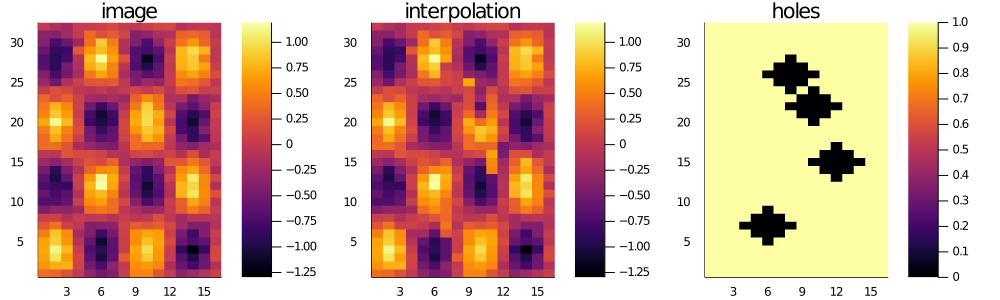

In [4]:
img_int = copy(img)
img_int[missing_inds] = fbar

p3 = heatmap(img_int, title="interpolation")

plot(p1,p3,p2,layout=(1,3),size=(1000,300))

In [5]:
hcat(img[missing_inds], fbar)

52×2 Array{Float64,2}:
 -0.0407079   0.0662085
 -0.422785   -0.210366
 -0.407386   -0.00497443
 -0.0383533   0.0819719
 -1.10106    -0.939092
 -0.82777    -0.613665
 -0.376553   -0.165925
 -0.0205037   0.223029
  0.453121    0.547496
  0.687477    0.782155
 -0.488706    0.252684
 -0.353598    0.434232
 -0.0959098   0.35975
  ⋮          
  0.464112    0.356792
  0.40165     0.303265
  0.075523   -0.12028
 -0.0724514  -0.158995
  0.228602   -0.217575
  0.0837038  -0.450144
 -0.0376175  -0.505413
 -0.0545244  -0.0285986
  0.563958    0.423931
  0.24096     0.306773
 -0.100863    0.181347
  0.44856     0.791914

From the KernelMatrices.jl tutorial on README

In [5]:
using LinearAlgebra, KernelMatrices, KernelMatrices.HODLR, StaticArrays, NearestNeighbors

# Choose the number of locations:
n    = 1024

# For the example, randomly generate some locations in the form of a Vector{SVector{2, Float64}}.
# You don't need to use an SVector here---there are no restrictions beyond the locations being a
# subtype of AbstractVector. I just use StaticArrays for a little performance boost.
locs = [SVector{2, Float64}(randn(2)) for _ in 1:n]

# Declare a kernel function with this specific signature. If you want to use the HODLR matrix
# format, this function needs to be positive definite. It absolutely does NOT need a nugget-like
# term on the diagonal to achieve this, but if the positive definite kernelfunction is analytic
# everywhere, including at the origin, you may encounter some numerical problems. To avoid writing
# something like the Matern covariance function here, I pick a simpler positive definite function
# and simply add a nugget to be safe.
function kernelfunction(x::AbstractVector, y::AbstractVector, p::AbstractVector{T})::T where{T<:Number}
  out = abs2(p[1])/abs2(1.0 + abs2(norm(x-y)/p[2]))
  if x == y
    out += 1.0
  end
  return out
end

# Choose some parameters for the kernel matrix. These will go in with the p argument in kernelfunction.
kprm = SVector{3, Float64}(ones(3))

# Create the kernel matrix! You can basically treat this like a regular array and do things like
# K[i,j], K[i,:], K[:,j], and so on. I also have implemented things like K*vec, but I encourage you
# not to use them, because they will be slow and kind of defeat the purpose.
# K    = KernelMatrices.KernelMatrix(locs, locs, kprm, kernelfunction)
K    = KernelMatrices.KernelMatrix(xx,xx, kprm, KernelMatrices.mtn_kernfun)

KernelMatrix{Float64,3,Array{Int64,1},typeof(KernelMatrices.mtn_kernfun)}([[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10]  …  [32, 7], [32, 8], [32, 9], [32, 10], [32, 11], [32, 12], [32, 13], [32, 14], [32, 15], [32, 16]], [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10]  …  [32, 7], [32, 8], [32, 9], [32, 10], [32, 11], [32, 12], [32, 13], [32, 14], [32, 15], [32, 16]], [1.0, 1.0, 1.0], KernelMatrices.mtn_kernfun)

In [6]:
# For the ACA, you need to choose:
  # A relative preocision for the off-diagonal block approximation (tol),
  # A fixed level (lvl),
  # An optional fixed maximum rank (rnk),
  # A parallel assembly option (pll).
tol  = 1.0e-12            # This flag works how you'd expect.
lvl  = HODLR.LogLevel(8)  # Sets the level at log2(n)-8. HODLR.FixedLevel(k) also exists and works how you'd expect.
rnk  = 0                  # If set to 0, no fixed max rank. Otherwise, this arg works as you'd expect.
pll  = false              # This flag determines whether assembly of the matrix is done in parallel.
HK_a = HODLR.KernelHODLR(K, tol, rnk, lvl, nystrom=false, plel=pll)

# For the Nystrom approximation, you need to choose:
  # An optional fixed level (lvl),
  # A fixed off-diagonal rank that is GLOBAL (rnk),
  # and a parallel assembly option.
# Note that "tol" is not actually used here. I could probably clean that code up some day.
n_rk = 2 # choose a valid fixed rank for off-diagonal blocks
HK_n = HODLR.KernelHODLR(K, tol, n_rk, lvl, nystrom=true, plel=pll)

┌ Warning: No default point sorting is done for you, and if your points are
│     not sorted properly the approximation can be very poor.
└ @ KernelMatrices.HODLR /Users/charlottehaley/.julia/packages/KernelMatrices/nM6A6/src/HODLR/src/constructor.jl:11


KernelHODLR{Float64}(1.0e-12, 1, 2, SArray{Tuple{4},Int64,1,4}[[1, 256, 1, 256], [257, 512, 257, 512]], Array{SArray{Tuple{4},Int64,1,4},1}[[[257, 512, 1, 256]]], [[[9.02525229293795e-10 6.503196005674624e-13; 8.64359939849017e-10 1.7095468211655074e-12; … ; 1.1250624715361364e-20 0.4443425236322361; 6.21763672558755e-21 1.0]]], [[[1.0 0.0; 0.4443425236322361 8.48786432168532e-21; … ; 1.7095468211655074e-12 8.64359939849017e-10; 6.503196005674624e-13 9.02525229293795e-10]]], Symmetric{Float64,Array{Float64,2}}[[1.0 0.4443425236322361 … 1.7095468211655074e-12 6.503196005674624e-13; 0.4443425236322361 1.0 … 4.331774487301751e-12 1.7095468211655074e-12; … ; 1.7095468211655074e-12 4.331774487301751e-12 … 1.0 0.4443425236322361; 6.503196005674624e-13 1.7095468211655074e-12 … 0.4443425236322361 1.0], [1.0 0.4443425236322361 … 1.7095468211655074e-12 6.503196005674624e-13; 0.4443425236322361 1.0 … 4.331774487301751e-12 1.7095468211655074e-12; … ; 1.7095468211655074e-12 4.331774487301751e-12 … 

In [7]:
HODLR.symmetricfactorize!(HK_n, plel=pll)

In [8]:
logdet(HK_n)

-191.63188591649686

In [9]:
HK_n\img[nonmissing_inds]

460-element Array{Float64,1}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN